In [ ]:
%pip install xformers

In [ ]:
%pip install matplotlib

## Hyper parameters 

In [7]:
######################################################
# Source Model
MODEL_NAME = "runwayml/stable-diffusion-v1-5"

######################################################
# DataSet
DEFAULT_PROMPT = "a photo of tiry person" 
CLASS_DIR = "tiry_pics_processed"     
RESOLUTION = 512

######################################################
## LORA
# Where Lora weights are stored
LORA_DIR = "sd-tiry-lora-xmas3"    
LORA_RANK=32
LORA_ALPHA=64

LORA_RANK=16
LORA_ALPHA=32

# TARGET MODULES
LORA_TARGET_MODULES = [
    "to_k", "to_q", "to_v", "to_out.0", # attention layers
#    "proj_in", "proj_out",              # feed forward 
#    "ff.net.0.proj", "ff.net.2", 
#    "time_emb_proj"
]

######################################################
# Training
TRAIN_STEPS = 2500       
BATCH_SIZE = 4           # Keep Batch 4 for speed
ACCUMULATION_STEPS = 1   
LEARNING_RATE = 1e-4


In [9]:
import os
import torch
import itertools
import gc
import bitsandbytes as bnb
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model
from torchvision import transforms
from PIL import Image
from accelerate import Accelerator

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
accelerator = Accelerator(
    mixed_precision="fp16",
    gradient_accumulation_steps=ACCUMULATION_STEPS 
)
# should have selected cuda
print("Accelerator device:", accelerator.device)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))

# --- PHASE 1: PRE-PROCESSING ---
print("PHASE 1: Encoding Images...")

tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(MODEL_NAME, subfolder="text_encoder").to(accelerator.device)
vae = AutoencoderKL.from_pretrained(MODEL_NAME, subfolder="vae").to(accelerator.device)

train_transforms = transforms.Compose([
    transforms.Resize(RESOLUTION, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

cached_data = []
# gather images
image_files = [f for f in os.listdir(CLASS_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for filename in image_files:
    # 1. Load Image
    img_path = os.path.join(CLASS_DIR, filename)
    img = Image.open(img_path).convert("RGB")
    # load img to GPU
    pixel_values = train_transforms(img).unsqueeze(0).to(accelerator.device)
    
    # 2. Load Caption 
    txt_path = os.path.splitext(img_path)[0] + ".txt"
    caption = DEFAULT_PROMPT # Default start
    
    if os.path.exists(txt_path):
        with open(txt_path, "r") as f:
            caption = f.read().strip()
    else:
        print(f"⚠️ Warning: No caption found for {filename}. Using default.")
    
    # 3. Encode Image (Latents /VAE )
    with torch.no_grad():
        latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor
        # free vram ?
        latents = latents.cpu()
        
    # 4. Encode Specific Caption (Embeddings)
    input_ids = tokenizer(
        caption, # Use the specific text for this image
        padding="max_length", 
        truncation=True, 
        max_length=tokenizer.model_max_length, 
        return_tensors="pt"
    ).input_ids.to(accelerator.device)
    
    with torch.no_grad():
        encoder_hidden_states = text_encoder(input_ids)[0].cpu()
        
    # we cache data computed in latent space for later use during training to be able to free everything else 
    # not 100% sure this is needed, but it helped when I was having steam playing tricks in the background :(
    cached_data.append({"latents": latents, "embeds": encoder_hidden_states})

del vae, text_encoder, tokenizer
torch.cuda.empty_cache()
gc.collect()

# --- PHASE 2: TRAINING ---
print(f"\nPHASE 2: Starting Training ({TRAIN_STEPS} Steps, Batch {BATCH_SIZE})...")

unet = UNet2DConditionModel.from_pretrained(MODEL_NAME, subfolder="unet")
noise_scheduler = DDPMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")

#freeze unet
unet.requires_grad_(False)

# vram usage optimization - may not be always needed
unet.enable_gradient_checkpointing()
try:
    unet.enable_xformers_memory_efficient_attention()
except:
    pass



# 2. LORA config
lora_config = LoraConfig(
    r=LORA_RANK,            # rank                           
    lora_alpha=LORA_ALPHA,  # High Signal Strength
    target_modules=LORA_TARGET_MODULES,
    init_lora_weights="gaussian",
)
unet = get_peft_model(unet, lora_config)
optimizer = bnb.optim.AdamW8bit(unet.parameters(), lr=LEARNING_RATE)

# move to GPU hopefully
unet, optimizer = accelerator.prepare(unet, optimizer)

# BATCH DATALOADER
class CachedDataset(torch.utils.data.Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

def collate_fn(examples):
    latents = torch.cat([ex["latents"] for ex in examples], dim=0)
    embeds = torch.cat([ex["embeds"] for ex in examples], dim=0)
    return {"latents": latents, "embeds": embeds}

train_dataloader = torch.utils.data.DataLoader(
    CachedDataset(cached_data), 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_fn
)
unet.train()
#data_iter = itertools.cycle(cached_data)
data_iter = itertools.cycle(train_dataloader)


for step in range(TRAIN_STEPS):
    batch = next(data_iter)
    
    latents = batch["latents"].to(accelerator.device, dtype=torch.float16)
    embeds = batch["embeds"].to(accelerator.device, dtype=torch.float16)

    noise_offset = 0.05
    noise = torch.randn_like(latents)
    noise = noise + noise_offset * torch.randn(latents.shape[0], latents.shape[1], 1, 1,device=latents.device, dtype=latents.dtype)

    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

    # predict noise
    model_pred = unet(noisy_latents, timesteps, embeds).sample
    # compute loss
    loss = torch.nn.functional.mse_loss(model_pred.float(), noise.float(), reduction="mean")
    # Backprop + optimizer step
    accelerator.backward(loss)
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)
    
    if step % 100 == 0:
        print(f"   Step {step}/{TRAIN_STEPS} | Loss: {loss.item():.4f}")

print("\n✅ Training Complete!")
unet.save_pretrained(LORA_DIR)

Accelerator device: cuda
CUDA available: True
CUDA device name: NVIDIA GeForce RTX 4070 Ti
PHASE 1: Encoding Images...

PHASE 2: Starting Training (2500 Steps, Batch 4)...
   Step 0/2500 | Loss: 0.0969
   Step 100/2500 | Loss: 0.1142
   Step 200/2500 | Loss: 0.2247
   Step 300/2500 | Loss: 0.2598
   Step 400/2500 | Loss: 0.0567
   Step 500/2500 | Loss: 0.1231
   Step 600/2500 | Loss: 0.0541
   Step 700/2500 | Loss: 0.1076
   Step 800/2500 | Loss: 0.1110
   Step 900/2500 | Loss: 0.3008
   Step 1000/2500 | Loss: 0.2132
   Step 1100/2500 | Loss: 0.1287
   Step 1200/2500 | Loss: 0.2419
   Step 1300/2500 | Loss: 0.0749
   Step 1400/2500 | Loss: 0.2049
   Step 1500/2500 | Loss: 0.0767
   Step 1600/2500 | Loss: 0.0617
   Step 1700/2500 | Loss: 0.0932
   Step 1800/2500 | Loss: 0.0573
   Step 1900/2500 | Loss: 0.1706
   Step 2000/2500 | Loss: 0.0815
   Step 2100/2500 | Loss: 0.0871
   Step 2200/2500 | Loss: 0.1186
   Step 2300/2500 | Loss: 0.1045
   Step 2400/2500 | Loss: 0.0942

✅ Training Com

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

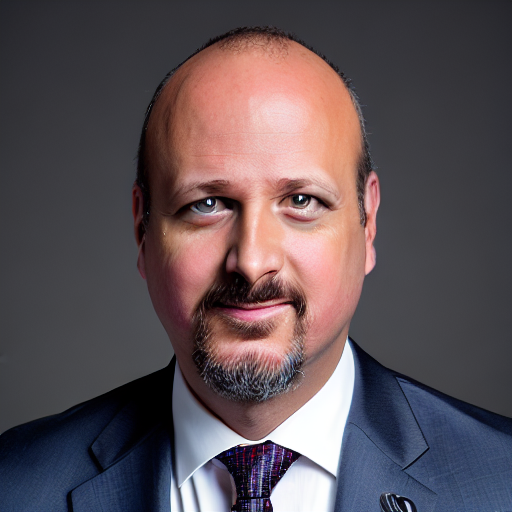

In [11]:
import torch
from diffusers import StableDiffusionPipeline
from peft import PeftModel

pipe = StableDiffusionPipeline.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, safety_checker=None).to("cuda")
pipe.unet = PeftModel.from_pretrained(pipe.unet, LORA_DIR)
pipe.unet.to("cuda")

prompt = "A professional headshot of tiry person in a suit, 8k, sharp focus, cinematic lighting, detailed eyes"
image = pipe(prompt, negative_prompt="blur, low quality, distortion, ugly", num_inference_steps=50).images[0]
display(image)

Loading Base Model...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading LoRA from sd-tiry-lora-xmas3...

Generating Test Grid...
   Generating Scale 0.8...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating Scale 0.9...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating Scale 1.0...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating Scale 1.1...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating Scale 1.2...


  0%|          | 0/50 [00:00<?, ?it/s]

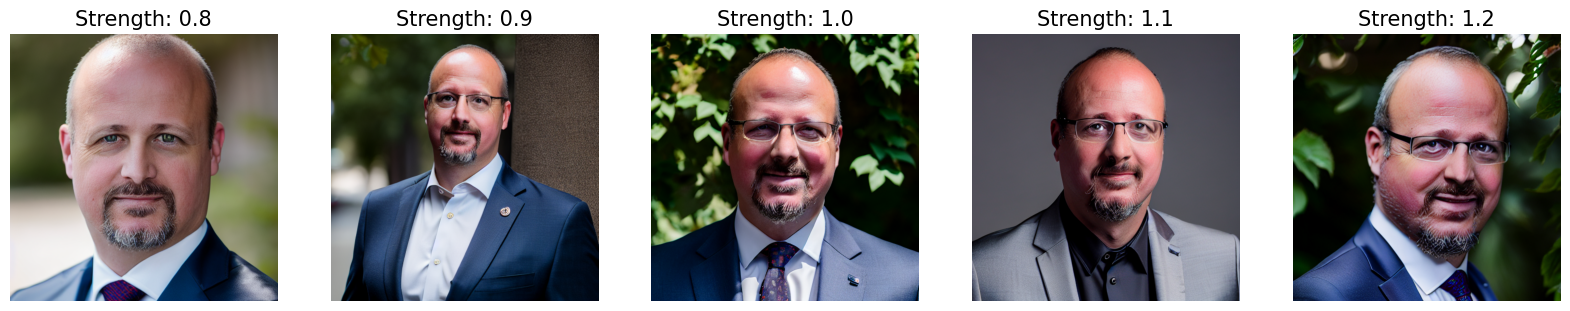

In [12]:
import torch
from diffusers import StableDiffusionPipeline
from peft import PeftModel
import matplotlib.pyplot as plt

# 1. Load Base
print("Loading Base Model...")
pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_NAME, 
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

# 2. Load Your Precision LoRA
print(f"Loading LoRA from {LORA_DIR}...")
pipe.unet = PeftModel.from_pretrained(pipe.unet, LORA_DIR)
pipe.unet.to("cuda")

# 3. Setup The Test
prompt = "A professional headshot of tiry person in a suit, 8k, sharp focus, cinematic lighting"
negative_prompt = "cartoon, drawing, anime, blur, low quality, distortion, ugly, deformed"
scales = [0.8, 0.9, 1.0, 1.1, 1.2] # Testing stronger weights

print("\nGenerating Test Grid...")
images = []
titles = []

for scale in scales:
    print(f"   Generating Scale {scale}...")
    image = pipe(
        prompt=prompt, 
        negative_prompt=negative_prompt, 
        num_inference_steps=50,
        guidance_scale=7.5,
        cross_attention_kwargs={"scale": scale} # The Magic Lever
    ).images[0]
    
    images.append(image)
    titles.append(f"Strength: {scale}")

# 4. Display Side-by-Side
fig, axs = plt.subplots(1, 5, figsize=(20, 6))
for i, (img, title) in enumerate(zip(images, titles)):
    axs[i].imshow(img)
    axs[i].set_title(title, fontsize=15)
    axs[i].axis("off")
plt.show()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Generating Showcase (5 prompts × 5 images)...
Prompt 1/5: A professional headshot of tiry person in a navy blue suit, ...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt 2/5: A candid photo of tiry person wearing a t-shirt at a coffee ...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt 3/5: A street photo of tiry person walking in New York City, over...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt 4/5: A cinematic portrait of tiry person, dramatic rim light, sha...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Prompt 5/5: Oil painting of tiry person as a viking warrior, fur armor, ...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

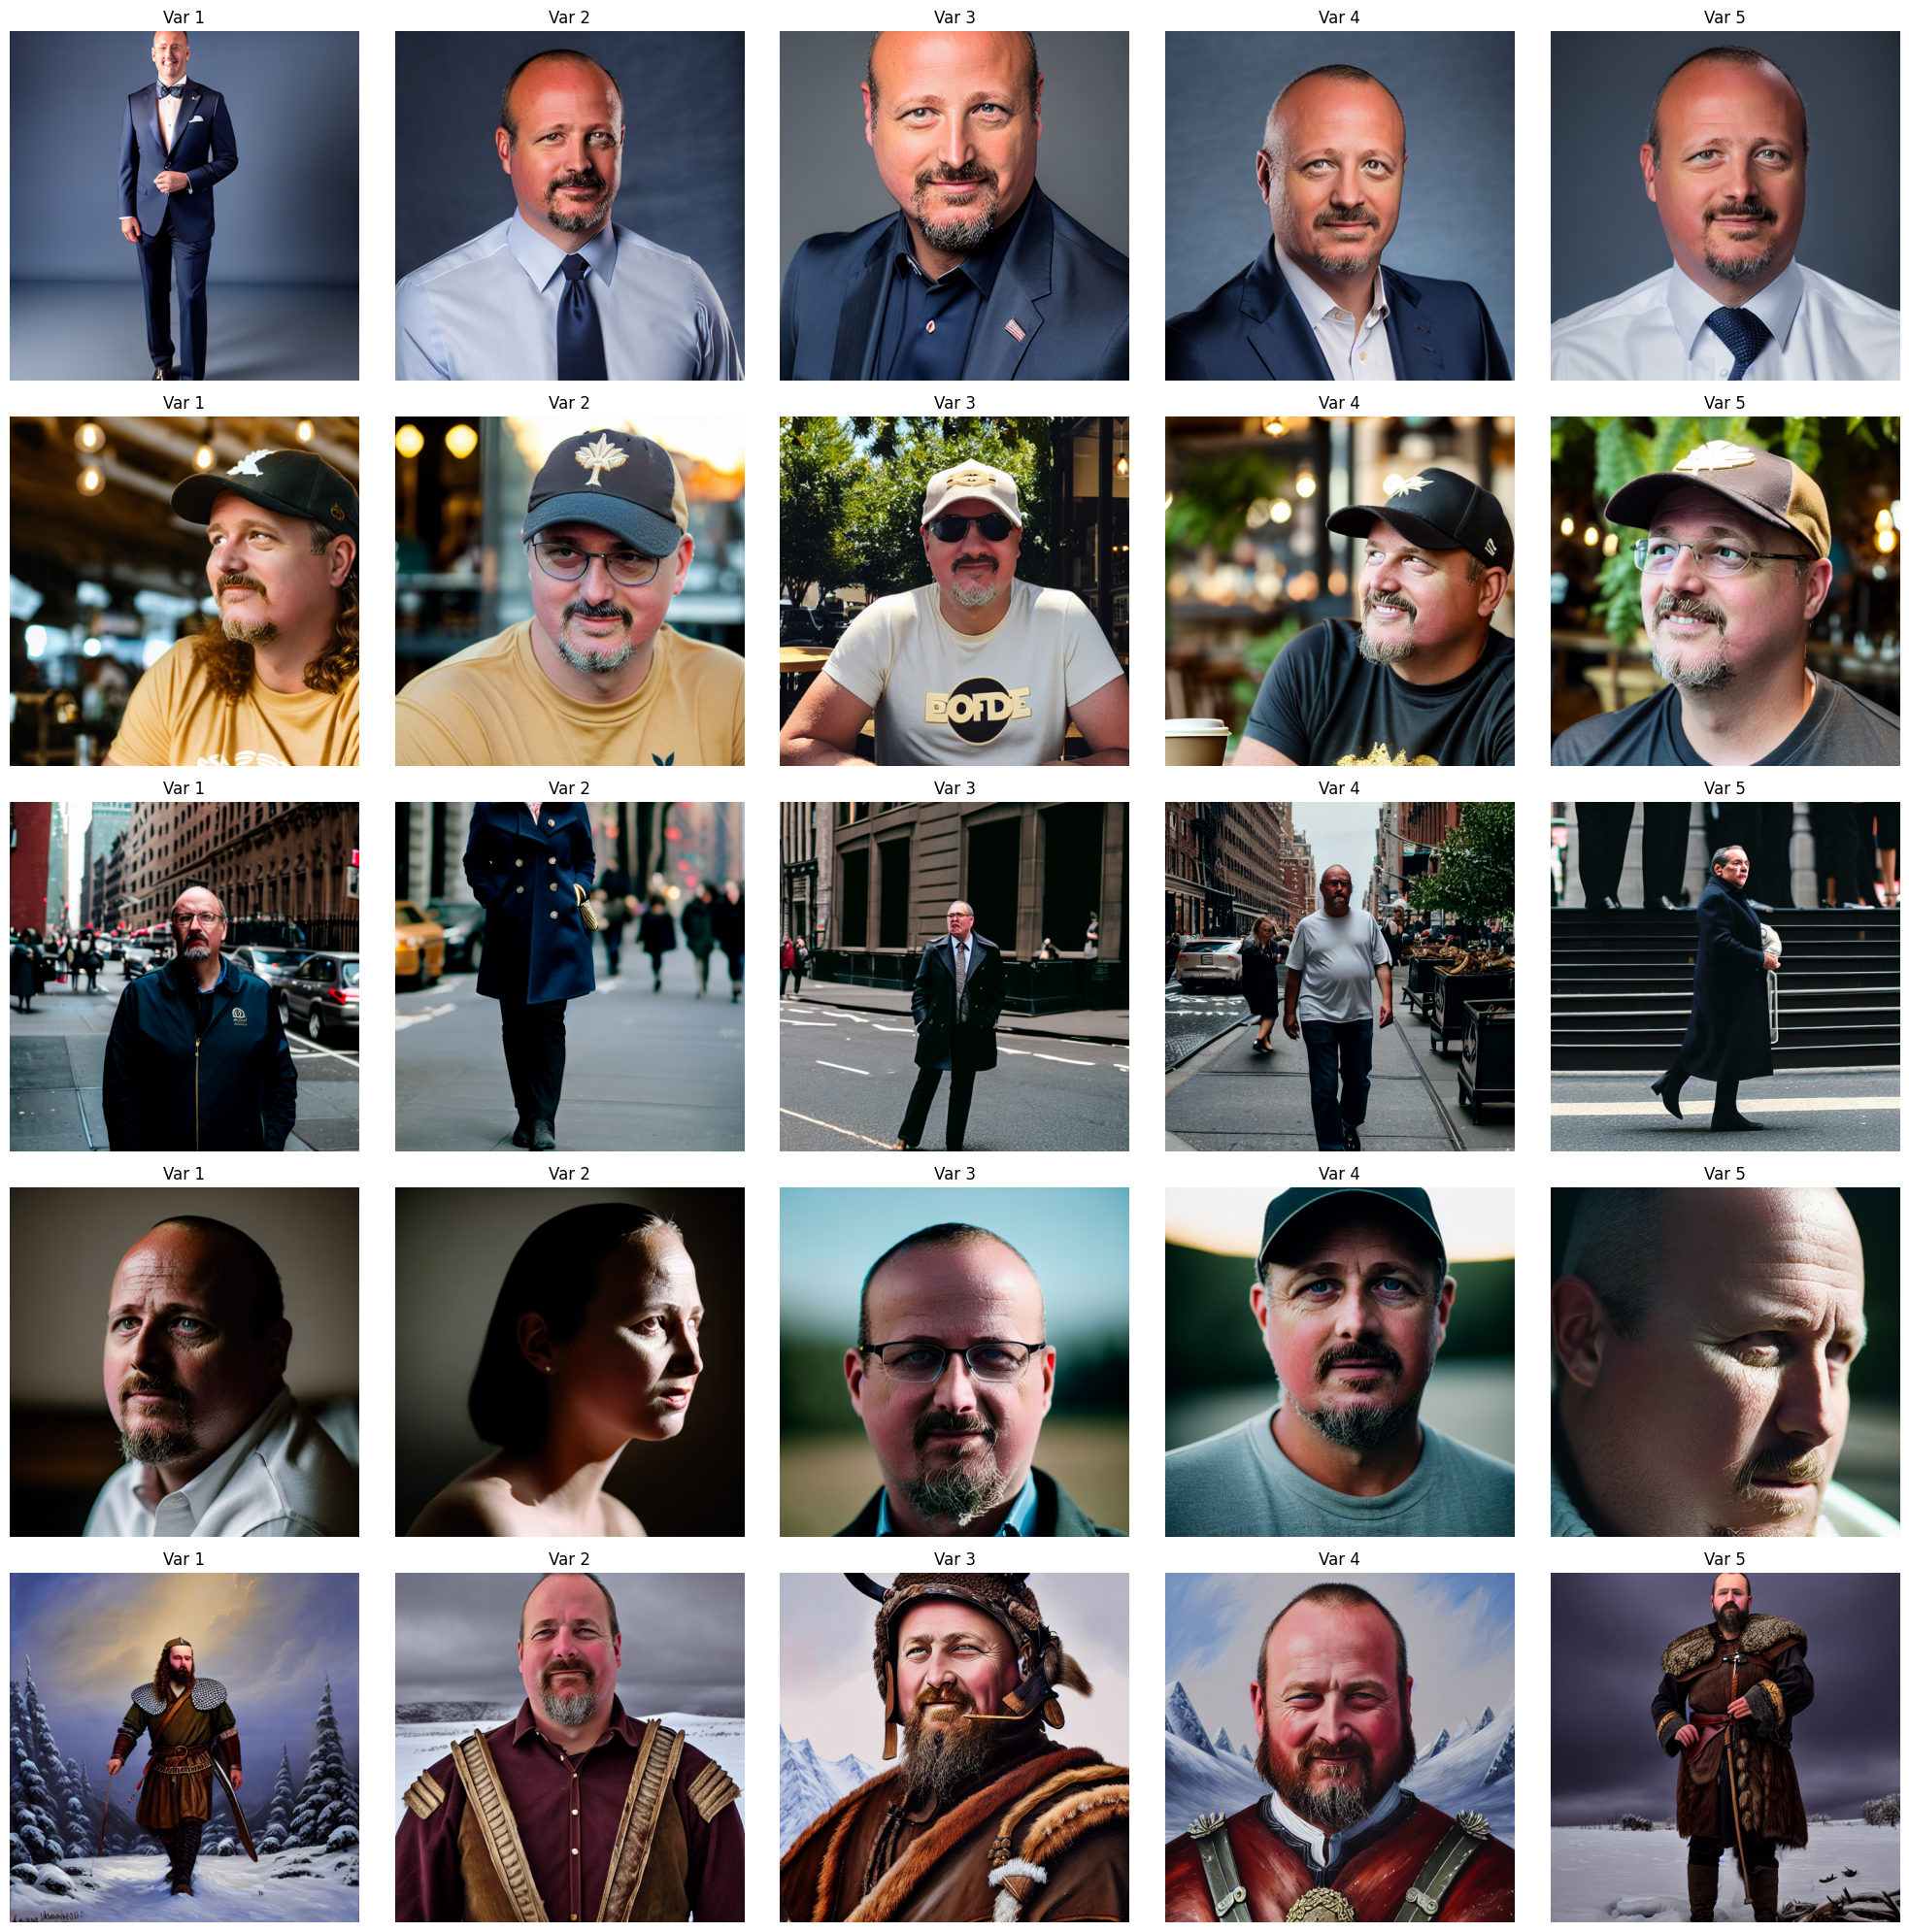

In [18]:
import torch
from diffusers import StableDiffusionPipeline
from peft import PeftModel
import matplotlib.pyplot as plt

# Assumes these are defined (from your config)
# MODEL_NAME = "runwayml/stable-diffusion-v1-5"
# LORA_DIR = "sd-tiry-lora-xmas2"

DEVICE = "cuda"
DTYPE = torch.float16

# 1) Load Base
pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_NAME,
    torch_dtype=DTYPE,
    safety_checker=None
).to(DEVICE)

# Optional but recommended for speed/memory
try:
    pipe.enable_xformers_memory_efficient_attention()
except Exception:
    pass

# 2) Load LoRA onto UNet
pipe.unet = PeftModel.from_pretrained(pipe.unet, LORA_DIR).to(DEVICE)

# 3) Five prompts (edit as you like)
prompts = [
    # 1. Professional
    "A professional headshot of tiry person in a navy blue suit, white shirt, studio lighting, sharp focus, canon 5d",

    # 2. Casual
    "A candid photo of tiry person wearing a t-shirt at a coffee shop, golden hour lighting, depth of field, bokeh",

    # 3. Outdoor / travel
    "A street photo of tiry person walking in New York City, overcast daylight, 35mm lens, natural skin texture, documentary style",

    # 4. Cinematic portrait
    "A cinematic portrait of tiry person, dramatic rim light, shallow depth of field, film grain, 85mm lens, realistic",

    # 5. Fantasy / stylized
    "Oil painting of tiry person as a viking warrior, fur armor, snow storm background, intricate beard detail, painterly, high detail",
]

negative_prompt = "cartoon, drawing, anime, blur, low quality, distortion, ugly, deformed, extra fingers"

# Generation params
NUM_PER_PROMPT = 5
NUM_INFERENCE_STEPS = 50
GUIDANCE_SCALE = 7.0
LORA_SCALE = 1.0  # you can try 1.1 or 1.2 if you prefer
HEIGHT = 512
WIDTH = 512

# Use fixed seeds for consistent variations across prompts
base_seed = 10000
generators = [torch.Generator(device=DEVICE).manual_seed(base_seed + i) for i in range(NUM_PER_PROMPT)]

print("Generating Showcase (5 prompts × 5 images)...")
all_images = []  # list of rows; each row has 5 images

for p_idx, p in enumerate(prompts):
    print(f"Prompt {p_idx+1}/{len(prompts)}: {p[:60]}...")
    row_imgs = []
    for i in range(NUM_PER_PROMPT):
        img = pipe(
            p,
            negative_prompt=negative_prompt,
            num_inference_steps=NUM_INFERENCE_STEPS,
            guidance_scale=GUIDANCE_SCALE,
            height=HEIGHT,
            width=WIDTH,
            generator=generators[i],
            cross_attention_kwargs={"scale": LORA_SCALE},
        ).images[0]
        row_imgs.append(img)
    all_images.append(row_imgs)

# 4) Display as a 5x5 grid
fig, axs = plt.subplots(len(prompts), NUM_PER_PROMPT, figsize=(NUM_PER_PROMPT * 4, len(prompts) * 4))

# If axs is 2D: axs[row][col]
for r in range(len(prompts)):
    for c in range(NUM_PER_PROMPT):
        ax = axs[r, c] if len(prompts) > 1 else axs[c]
        ax.imshow(all_images[r][c])
        if c == 0:
            ax.set_ylabel(f"Prompt {r+1}", fontsize=12)
        ax.set_title(f"Var {c+1}", fontsize=12)
        ax.axis("off")

plt.tight_layout()
plt.show()